### This file has code for Simulation of Stochastic Processes

    1. Expected values and probabilities of multivariate stochastic equation
    2. Call option pricing using Monte Carlo Simulations
    3. 2-factor model for stock prices with stochastic volatility
    4. Pseudo-random numbers with a sample of quasi-MC numbers
    5. Halton sequences

In [1]:
import numpy as np
from numpy import sqrt, log, sin, cos, exp, pi, mean, repeat
from scipy.stats import norm
import matplotlib.pyplot as plt


(-0.004883898297003371, 0.026114396772740626, 0.026163659530512088)

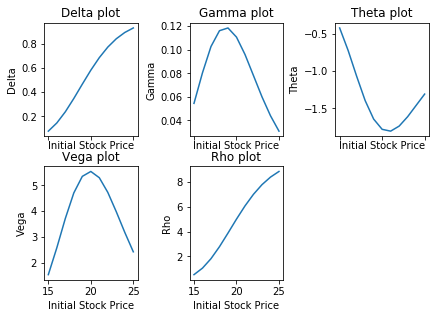

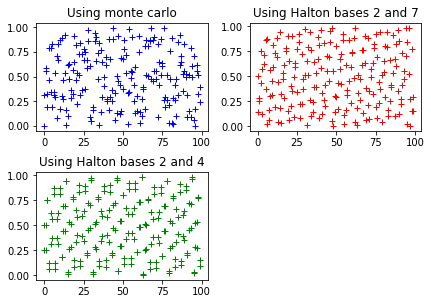

In [2]:

#Question 1
def func1(seed1, seed2):
  
  #Simulating X
  np.random.seed(seed1)
  paths_count = 1000
  T = 2
  dt = 0.01
  x_paths = np.random.randn(paths_count, int(T/dt))
  x = np.zeros((paths_count, int(T/dt)))
  x[:, 0] = 1 #X0 = 1
  for i in range(paths_count-1):
      for j in range(int(T/dt)-1):
          x[i, j+1] = x[i, j] + (1/5 - 1/2*x[i, j])*dt + 2/3*sqrt(dt)*x_paths[i, j+1]
  
  #Simulating Y
  np.random.seed(seed2)
  T = 3
  y_paths = np.random.randn(paths_count, int(T/dt))
  y = np.zeros((paths_count, int(T/dt)))
  y[:, 0] = 3/4
  for i in range(paths_count-1):
      for j in range(int(T/dt)-1):
          y[i, j+1] = y[i, j] + ( (2/(1+j*dt))*y[i, j] + (1+(j*dt)**3)/3 ) * dt + ((1+(j*dt)**3)/3)*sqrt(dt)*y_paths[i, j+1]
  
  #p(y2>5)
  y2 = y[:,200-1]
  prob = len(y2[y2>5])/paths_count 
  
  # E(x2^1/3)
  E1 =  mean(np.cbrt(x[:, 200-1]))
  
  # E(Y3)
  E2 = mean(y[:, 300-1])
  x2 = x[:, 200-1]
  x2_gt1 = np.where(x2>1, 1, 0)
  D3 =  x2*y2*x2_gt1    
  #D3[D3==0] = np.nan
  E3 = mean(D3)
  
  return prob, E1, E2, E3  
  


# In[3]:


func1(200, 100)


# In[4]:


#Question 2
def func2(seed1, seed2):
    
    paths_count = 1000
    T = 3
    dt = 0.01
    np.random.seed(seed1)
    dw = np.random.randn(paths_count, int(T/dt))
    np.random.seed(seed2)
    dz = np.random.randn(paths_count, int(T/dt))
    
    #simulating x
    x = np.zeros((paths_count, int(T/dt)))
    x[:, 0] = 1
    for i in range(paths_count-1):
        for j in range(int(T/dt)-1):
            x[i, j+1] = x[i, j] + x[i, j]*( (1/4)*dt + 1/3*sqrt(dt)*dw[i, j+1] - 3/4*sqrt(dt)*dz[i, j+1] )
    
    
    #Simulating Y
    dw_cum = np.cumsum(dw, axis=1)
    dz_cum = np.cumsum(dz, axis=1)
    t = np.arange(0, 3, dt)
    yt = exp(-0.08*t+(1/3)*sqrt(dt)*dw_cum+(3/4)*sqrt(dt)*dz_cum)
    
    E1 = mean(np.cbrt(1+x[:, int(3/dt)-1]))
    
    E2 = mean(np.cbrt(1+yt[:, int(3/dt)-1]))
    
    return E1, E2


# In[5]:


func2(1234, 100)


# In[6]:


#Question 3 a
def callPrice_mc(S_o, T, X, r, sigma):
    
    #European call via Monte Carlo with Antithetic Variance Reduction
    np.random.seed(1234)
    u1 = np.random.randn(1000)
    u2 = -u1
    ST1 = S_o*exp(sigma*(sqrt(T)*u1)+(r-sigma**2/2)*T)
    ST2 = S_o*exp(sigma*(sqrt(T)*u2)+(r-sigma**2/2)*T)
    STX1 = ST1 - X
    STX2 = ST2 - X
    STX1 = np.where(STX1>0, STX1, 0)
    STX2 = np.where(STX2>0, STX2, 0)
    c1 = mean( (exp(-r*T)*STX1 + exp(-r*T)*STX2)/2 )
    return c1


# In[7]:


# Testing with sample input
callPrice_mc(18, 0.5, 20, 0.04, 0.25)


# In[8]:


#Question 3b
def callPrice_bs(S_o, T, X, r, sigma):
    #European call price using Black Scholes
    d1 = (log(S_o/X) + (r+sigma**2/2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    #numerical computation of normcdf N(.)
    p1 = 0.0498673470
    p2 = 0.0211410061
    p3 = 0.0032776263
    p4 = 0.0000380036
    p5 = 0.0000488906
    p6 = 0.0000053830
    
    f = lambda x : 1- 1/2*(1+p1*x+p2*x**2+p3*x**3+p4*x**4+p5*x**5+p6*x**6)**(-16) 
    Nd1 = f(d1) if d1 >= 0 else 1-f(-d1)
    Nd2 = f(d2) if d2 >= 0 else 1-f(-d2) 
    c2 = Nd1*S_o - Nd2*X*exp(-r*T)
    return c2


# In[9]:


callPrice_bs(18, 0.5, 20, 0.04, 0.25)


# In[25]:


#Question 3c
def greek(S_o, T, X, r, sigma):
   
    d1 = (log(S_o/X) + (r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    
    Delta = norm.cdf(d1)
    Gamma = norm.pdf(d1)/(S_o*sigma*np.sqrt(T))
    Rho = X*T*np.exp(-r*T)*norm.cdf(d2)
    Theta = (-S_o*sigma*norm.pdf(d1)/(2*np.sqrt(T))) - r*X*np.exp(-r*T)*norm.cdf(d2)
    Vega = S_o*np.sqrt(T)*norm.pdf(d1)
   
    #plotting
    fig, axe = plt.subplots(2,3, sharex=True)
    fig.tight_layout(pad=0.5, w_pad=1.5, h_pad=2.0)
    axe[0, 0].plot(S_o, Delta)
    axe[0, 0].set_xlabel("Initial Stock Price")
    axe[0, 0].set_ylabel("Delta")
    axe[0, 0].set_title("Delta plot")
    
    axe[0, 1].plot(S_o, Gamma)
    axe[0, 1].set_xlabel("Initial Stock Price")
    axe[0, 1].set_ylabel("Gamma")
    axe[0, 1].set_title("Gamma plot")
   
    axe[0, 2].plot(S_o, Theta)
    axe[0, 2].set_xlabel("Initial Stock Price")
    axe[0, 2].set_ylabel("Theta")
    axe[0, 2].set_title("Theta plot")
    
    axe[1, 0].plot(S_o, Vega)
    axe[1, 0].set_xlabel("Initial Stock Price")
    axe[1, 0].set_ylabel("Vega")
    axe[1, 0].set_title("Vega plot")
    
    axe[1, 1].plot(S_o, Rho)
    axe[1, 1].set_xlabel("Initial Stock Price")
    axe[1, 1].set_ylabel("Rho")
    axe[1, 1].set_title("Rho plot")
    
    axe[1, 2].set_visible(False) 
        
    return Delta, Gamma, Theta, Vega, Rho 


# In[26]:


greek(S_o=np.arange(15, 26, 1), T=0.5, X=20, r=0.04, sigma=0.25)


# In[7]:


#Question 4
def func4(seed, T = 3, K = 50):
   
    np.random.seed(seed)
    path = 1000
    dt = 0.01
    dw = np.random.randn(2*path, int(T/dt))
    dw1 = np.split(dw, 2)[0]
    dz2 = np.split(dw, 2)[1]
   
     
    #simulating volatility
    v = np.zeros((path, int(T/dt)))
    v[:, 0] = 0.05
    rho= -0.6
    r = 0.03
    S_o = 48
    sigma = 0.42
    alpha = 5.8
    beta = 0.0625
    dw2 = rho*sqrt(dt)*dw1 + sqrt(1-rho**2)*sqrt(dt)*dz2
    
    ####### Full Trucation method
    #Volatility simulation
    for i in range(path-1):
        for j in range(int(T/dt)-1):
            v[i, j+1] = v[i, j] + alpha*(beta - max(v[i, j], 0))*dt + sigma*sqrt(max(v[i, j], 0))*dw2[i, j+1]
    
    #simulating stock
    s = np.zeros((path, int(T/dt)))
    s[:, 0] = S_o
    for i in range(path-1):
        for j in range(int(T/dt)-1):
            s[i, j+1] = s[i, j] + r*s[i, j]*dt + sqrt(max(v[i, j], 0))*s[i, j]*sqrt(dt)*dw1[i, j+1]
    
    STX = s[:,int(T/dt)-1]  - K
    STX = np.where(STX>0, STX, 0)
    c1 = mean(exp(-r*T)*STX)
    
    ####### Partial Trucation method
    #Volatility simulation
    for i in range(path-1):
        for j in range(int(T/dt)-1):
            v[i, j+1] = v[i, j] + alpha*(beta - v[i, j])*dt + sigma*sqrt(max(v[i, j], 0))*dw2[i, j+1]
    
    #simulating stock
    s = np.zeros((path, int(T/dt)))
    s[:, 0] = S_o
    for i in range(path-1):
        for j in range(int(T/dt)-1):
            s[i, j+1] = s[i, j] + r*s[i, j]*dt + sqrt(max(v[i, j], 0))*s[i, j]*sqrt(dt)*dw1[i, j+1]
          
    STX = s[:,int(T/dt)-1]  - K
    STX = np.where(STX>0, STX, 0)
    c2 = mean(exp(-r*T)*STX)
    
    ####### Reflection method
    #Volatility simulation
    for i in range(path-1):
        for j in range(int(T/dt)-1):
            v[i, j+1] = abs(v[i, j]) + alpha*(beta - abs(v[i, j]))*dt + sigma*sqrt(abs(v[i, j]))*dw2[i, j+1]
    
    #simulating stock
    s = np.zeros((path, int(T/dt)))
    s[:, 0] = S_o
    for i in range(path-1):
        for j in range(int(T/dt)-1):
            s[i, j+1] = s[i, j] + r*s[i, j]*dt + sqrt(abs(v[i, j]))*s[i, j]*sqrt(dt)*dw1[i, j+1]
          
    STX = s[:,int(T/dt)-1]  - K
    STX = np.where(STX>0, STX, 0)
    c3 = mean(exp(-r*T)*STX)
    
    return c1, c2, c3
   


# In[9]:


func4(100, 1, 50) 


# In[27]:


def genRandUnif(n, seed=100, LGMm=2**31-1, LGMa=7**5):
    x=np.array([seed], dtype=np.float64)
    u=np.array([], dtype=np.float64)
    for i in range(n):
        rand = (LGMa*x[i]) % LGMm
        x = np.append(x, rand)
        u = np.append(u, rand/LGMm)
    return u   

#Generates Halton Sequence 
# Code help taken from Class notes matlab code and implemented in Python
def genHalton(size, base):
    seq = np.zeros(size)
    bits = 1+np.ceil(log(size)/log(base))
    VetBase = pow(base, -np.arange(bits+1))
    WorkVet = np.zeros(int(bits+1))
    for i in range(size):
        j = 1
        ok = 0
        while ok == 0:
            WorkVet[j] = WorkVet[j]+1
            if(WorkVet[j] < base):
                ok = 1
            else:
                WorkVet[j] = 0
                j = j+1
        
        seq[i] = sum(WorkVet*VetBase)
    return seq
            
       
def func5(seed):
    #using own random number generator
    mc_rand = genRandUnif(100*2, seed=seed)
    mc_rand = mc_rand.reshape((100, 2))
    
    fig, axe = plt.subplots(2,2)
    fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=2.0)
    axe[0, 0].plot(mc_rand, 'b+')
    axe[0, 0].set_title("Using monte carlo")
    
    #using Halton  bases 2 and 7
    halton2 = genHalton(100, 2)
    halton7 = genHalton(100, 7)
    halton2_7 = np.stack((halton2, halton7), axis=1)
    
    axe[0, 1].plot(halton2_7, 'r+')
    axe[0, 1].set_title("Using Halton bases 2 and 7")
    
    #using Halton bases 2 and 4
    halton2 = genHalton(100, 2)
    halton4 = genHalton(100, 4)
    halton2_4 = np.stack((halton2, halton4), axis=1)
    
    axe[1, 0].plot(halton2_4, 'g+')
    axe[1, 0].set_title("Using Halton bases 2 and 4")
    axe[1, 1].set_visible(False) 
    
    #5.e
    f = lambda x, y: exp(-x*y)*(sin(6*pi*x)+np.cbrt(cos(2*pi*y)))
    
    N = 10000
    halton2 = genHalton(N, 2)
    halton4 = genHalton(N, 4)
    halton5 = genHalton(N, 5)
    halton7 = genHalton(N, 7)
    
    I2_4 = mean(f(halton2, halton4))
    I2_7 = mean(f(halton2, halton7))
    I5_7 = mean(f(halton5, halton7))

    return I2_4, I2_7, I5_7


# In[28]:


func5(10) 


# Out of the three integrations, Helton(2,4) sequence is not giving the right answer due to bases not being mutually prime.<br>
# Helton(2,7), helton(5,7) are close to the right answer.<br><br>
# Monte carlo simulated points are not coverting the entire area (descrepency).<br>
# Using Halton sequence with base 2 and 4, there is a pattern of descrepency. Diagonal parallel stripes of uncovered area(descrepency)<br>
# Using Halton sequence with base 2 and 7 covers the entire area more uniformly. Lowest descrepency among all three sumulations.
